In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
# scikit-learn on erittäin kiva kirjasto jota kaikki datatiedeilijät käyttävät. Sen saa condaan asennettua:
# conda install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error
from sklearn.linear_model import LinearRegression

In [2]:
# Luetaan valmiiksi pureskeltu data GitHubista Pickle tiedostona. Kyseessä on kurssin Tampereen BNB data. 
df_train_filtered = pd.read_pickle('https://raw.githubusercontent.com/THalfar/JoDa/main/df_train_filtered.pkl')

# Katsotaan millainen pureskeltu data on 
df_train_filtered.head()

,Kaupunginosa,Talot.,m2,Rv,Hissi,Kunto,Asunnon tyyppi,Pituusaste,Leveysaste,Hinta,...,parveke,parvi,ph,rp,rt,sauna,vh,wc,kerros,max_kerros
0,20,0,50.0,2020,1,3,2,23.696606,61.524269,300,...,1,0,0,0,0,1,0,0,2,6
1,32,0,28.0,2018,1,3,1,23.804092,61.433185,162,...,0,0,0,0,0,0,0,0,1,4
2,20,0,63.0,2020,1,3,3,23.696636,61.519368,363,...,1,0,0,0,0,1,0,0,3,6
3,15,0,84.0,1964,1,0,3,24.062369,61.463896,483,...,0,0,0,0,0,0,1,1,5,7
4,6,0,52.0,1995,1,2,2,23.848751,61.446601,174,...,1,0,1,0,0,1,0,0,6,6


In [3]:
# Koska Talot. tyyppejä ei ole kovin montaa, niin yhdistetään ne kaupunginosan kanssa jonka mukaan tehdään testi data setti
df_train_filtered['combined'] = df_train_filtered[['Kaupunginosa', 'Talot.']].astype(str).agg('-'.join, axis=1)
counts = df_train_filtered['combined'].value_counts()
df_train_filtered['combined'] = df_train_filtered['combined'].map(lambda x: 'other' if counts[x] < 2 else x)

X = df_train_filtered.drop('Hinta', axis=1)
y = df_train_filtered['Hinta']

# Tässä haluan ositella datan opetus ja testi dataan. Testi datasta 10% ja opetus datasta 90%. Keskeistä että osisttelu tehdään sekä kaupunginosien 
# että talotyyppien mukaan. Tämä on tärkeää, koska muuten testidata voi olla vinoutunut ja malli ei opi oikein.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=df_train_filtered['combined'], random_state=42)

# Poistetaan tämä ositteluun käytetty tieto. 
X_train.drop('combined', axis=1, inplace=True)
X_test.drop('combined', axis=1, inplace=True)


In [4]:
# Hinta arvioissa on tärkeää suhteelliset virheet, ei absoluuttiset. Joten käytetään RMSLE virhettä. 
# Kyseessä on logaritminen virhe jolloin virheiden suhteet tulevat oikein esille. 
# 100e kämpässä 10e virhe on suhteellisesti sama kuin 1000e kämpässä 100e virhe. 

def rmsle_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.log1p(y_true+1), np.log1p(y_pred+1)))

In [5]:
# Lineaarinen regressio on yksinkertainen malli joka yrittää sovittaa suoran datan pisteiden läpi. Tämä on kökkö mutta toimii hyvin monissa tapauksissa.
lr = LinearRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print(f"Neliöllinen keskivirhe: {mse:.2f}\nNeliöllinen absoluuttinen virhe: {mae:.2f}\nR2-arvo: {r2:.2f}\nRMSLE: {rmsle_score(y_test, predictions):.2f}")


Neliöllinen keskivirhe: 10661.28
Neliöllinen absoluuttinen virhe: 73.46
R2-arvo: 0.54
RMSLE: 0.31


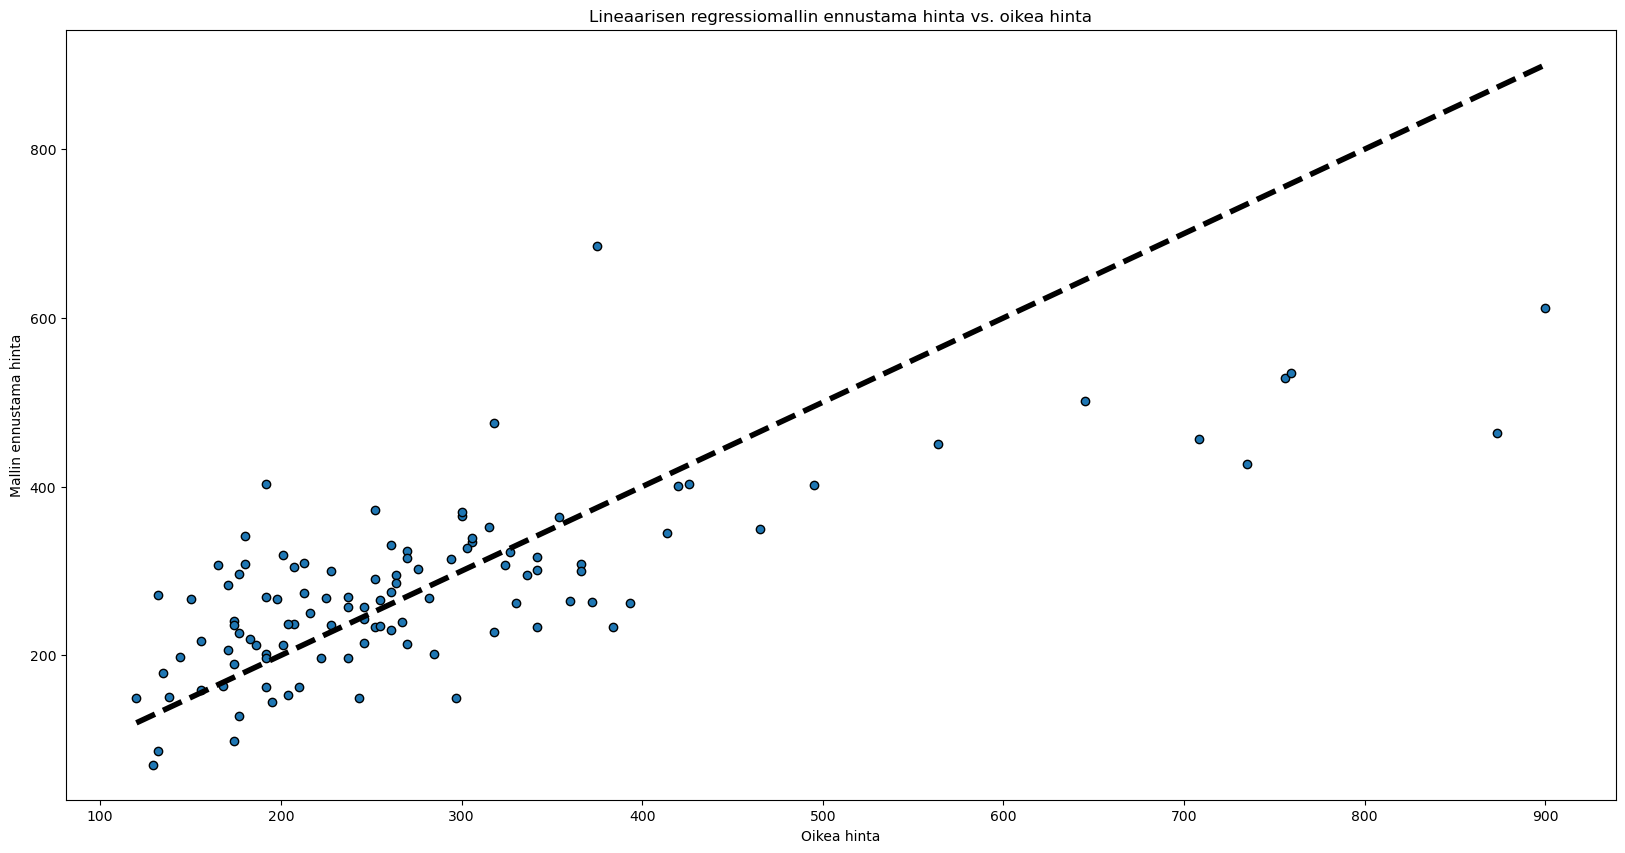

In [6]:
# Tehdään vielä hieno käppyrä mistä näkee, kuinka lineaarinen regressiomalli on kökkö tässä tarkoituksessa.
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Oikea hinta')
ax.set_ylabel('Mallin ennustama hinta')
plt.title('Lineaarisen regressiomallin ennustama hinta vs. oikea hinta')
plt.show()